# Cell types Data Tutorial

____________

In this tutorial we will see how to use experimental data from the [Neocortical Microcircuit Collaboration Portal](https://bbp.epfl.ch/nmc-portal/) (NMC)
____________


Authors of this script:

Elisabetta Iavarone @ Blue Brain Project

Werner Van Geit @ Blue Brain Project
___
### Overview:

* In this exercise we will use the **Blue Brain Python Optimisation Library** [BluePyOpt](https://github.com/BlueBrain/BluePyOpt) to create a model template for the [NEURON simulator](https://www.neuron.yale.edu/neuron/) and to constrain the model parameters.
____

You can run this tutorial on your computer, for installation instruction, look [here](https://github.com/BlueBrain/SimulationTutorials/tree/master/General/Installation)
___

We first import some useful Python modules.

<IPython.core.display.Javascript object>


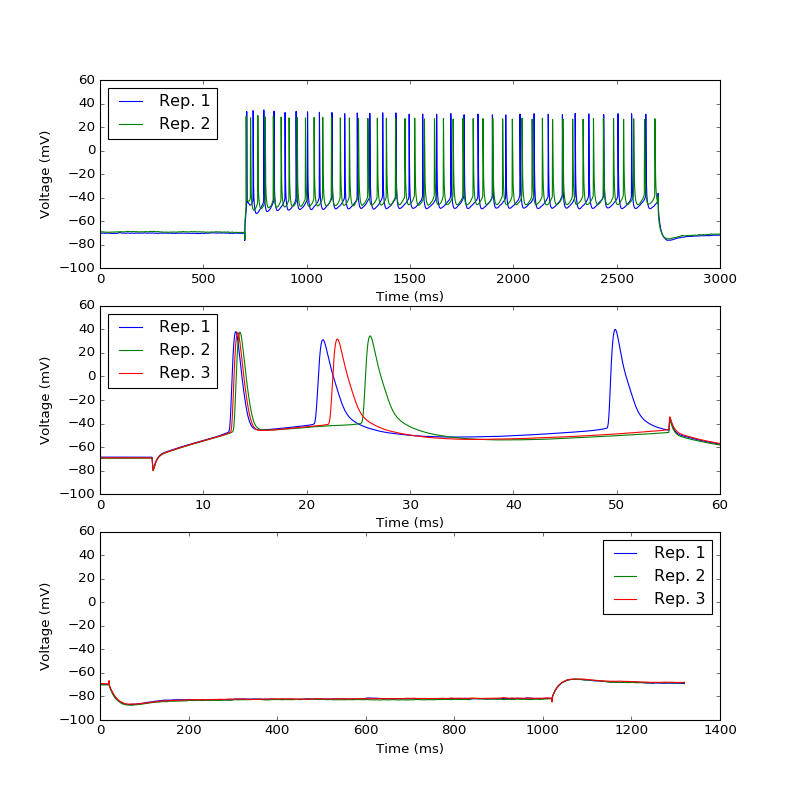

In [1]:
%load_ext autoreload
%autoreload

import numpy
import json
import IPython
from json2html import *

import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['figure.figsize'] = 10, 10

import collections

import efel
import neurom

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import pprint
pp = pprint.PrettyPrinter(indent=2)

# Define the directory containing the voltage traces
data_dir = 'data/'

# Store data in a dictionary step_name : [list of repetitions]
#steps_dict = collections.OrderedDict(sorted({'StepNeg':23,'StepPos':36}.items(), key = lambda x:x[0]))
steps_dict = collections.OrderedDict({'LongStepNeg': [], 'ShortStepPos': [], 'LongStepPos': []})

# Import the os Python module to interact with the operating system
import os
from glob import glob

files_list = glob(data_dir + "*.txt")

for file_name in files_list:
    if "APWaveform" in file_name:
        steps_dict['ShortStepPos'].append(numpy.loadtxt(file_name))
    if "IDrest" in file_name:
        steps_dict['LongStepPos'].append(numpy.loadtxt(file_name))
    if "IV" in file_name:
        steps_dict['LongStepNeg'].append(numpy.loadtxt(file_name))
        
fig1, axes = plt.subplots(len(steps_dict), sharey = True)
for idx, step_name in enumerate(steps_dict.keys()):
    for rep, trace in enumerate(steps_dict[step_name]):
        axes[idx].plot(trace[:,0],trace[:,1], label = 'Rep. ' + str(rep+1))
        axes[idx].set_ylabel('Voltage (mV)')
        axes[idx].set_xlabel('Time (ms)')
        axes[idx].legend(loc = 'best')
        #axes[idx].set_xlim([0,3])

# 2. Electrophysiological features
To build a detailed neuron model, we need to quantify the electrical behavior we want to reproduce. The metrics we use are the eFeatures, that measure parameters describing for instance the shape of the action potential or the firing properties of a neuron (for examples, see [here](http://bluebrain.github.io/eFEL/eFeatures.html)).

In this particular example, we extract distinct features from the responses to the negative and positive voltage steps.
The eFeatures extracted from the data and later from the model will be used to evaluate the results of the simulations. The features values, along with the standard deviations are stored in a .json file.

In [2]:

# Extract features
import efel

# Define stimulus start and end times
steps_info = {'LongStepNeg': [20, 1020], 'ShortStepPos': [5, 55], 'LongStepPos': [700, 2700]}

# Prepare the traces for eFEL
def get_features(data):
    # All the traces converted in eFEL format
    efel_traces = {'LongStepNeg': [], 'ShortStepPos': [], 'LongStepPos': []}
    for step_name, step_traces in data.items():
        for rep in step_traces:
            # A single eFEL trace 
            trace = {}
            trace['T'] = rep[:,0]
            trace['V'] = rep[:,1]-14 # Correct for liquid junction potential
            trace['stim_start'] = [steps_info[step_name][0]]
            trace['stim_end'] = [steps_info[step_name][1]]
            trace['name'] = step_name
            
            efel_traces[step_name].append(trace)
    
    features_values = collections.defaultdict(dict)       
    
    features_values['LongStepNeg'] = efel.getMeanFeatureValues(efel_traces['LongStepNeg'], 
                                                                ['time_constant', 'voltage_deflection_begin', 
                                                                'voltage_deflection'])
    
    features_values['LongStepPos'] = efel.getMeanFeatureValues(efel_traces['LongStepPos'], 
                                                               ['mean_frequency', 'adaptation_index2', 
                                                                'ISI_CV', 'doublet_ISI'])
    
    features_values['ShortStepPos'] = efel.getMeanFeatureValues(efel_traces['ShortStepPos'], 
                                                                ['time_to_first_spike', 'AHP_depth', 
                                                                'AP_width', 'AP_height', 'time_to_first_spike'])    
    
    mean_std_features = collections.defaultdict(lambda:collections.defaultdict(dict))
    for step_name in features_values:
        for efeature in features_values[step_name][0]:
            efeature_values = [x[efeature] for x in features_values[step_name]]
            mean_std_features[step_name][efeature] = {'mean': numpy.mean(efeature_values), 
                                                      'std': numpy.std(efeature_values)}
    
    return mean_std_features

mean_std_features = get_features(steps_dict)
IPython.display.HTML(json2html.convert(json=dict(mean_std_features)))

# 3. Model definition
In this section we will define the neuron model template and the parameters that we will optimize later on. The fixed parameters are taken from the "Biophysical - All active" model from the ABI models database. To download the original model and data uncomment the following lines (before you would need to create a folder called "neuronal model").

In the following steps we will use some BluePyOpt functionalities to set-up the model template and optimize the free parameters. First of all, we use the "ephys" module to load the morphology. The axon is replaces by a model of the axonal initial segment (AIS).

In [3]:
morphology_file = 'simple.swc'
morphology = ephys.morphologies.NrnFileMorphology(morphology_file)

somatic_loc = ephys.locations.NrnSeclistLocation('somatic', seclist_name='somatic')

The ion channel parameters and distribution in the different compartments (soma, basal dendrite, AIS) are stored in a .json file (in "config/parameters.json")

In [4]:
hh_mech = ephys.mechanisms.NrnMODMechanism(                                         
        name='hh',                                                                  
        suffix='hh',                                                                
        locations=[somatic_loc])   
gnabar_param = ephys.parameters.NrnSectionParameter(                                    
        name='gnabar_hh',                                                           
        param_name='gnabar_hh',                                                     
        locations=[somatic_loc],                                                    
        bounds=[0.0, 1],
        frozen=False)                                                            
gkbar_param = ephys.parameters.NrnSectionParameter(                              
        name='gkbar_hh',                                                         
        param_name='gkbar_hh',                                                   
        #bounds=[0.01, 0.075],
        bounds=[0.01, 1],
        locations=[somatic_loc],                                                 
        frozen=False) 
gl_param = ephys.parameters.NrnSectionParameter(                                    
        name='gl_hh',                                                           
        param_name='gl_hh',                                                     
        locations=[somatic_loc],                                                    
        value=1e-4,
        frozen=True)  
el_param = ephys.parameters.NrnSectionParameter(                                    
        name='el_hh',                                                           
        param_name='el_hh',                                                     
        locations=[somatic_loc],                                                    
        value=-70,
        frozen=True)
cm_param = ephys.parameters.NrnSectionParameter(                                 
        name='cm',                                                               
        param_name='cm',                                                         
        value=2.0,                                                               
        locations=[somatic_loc],                                                 
        frozen=True)   
celsius_param = ephys.parameters.NrnGlobalParameter(                                 
        name='celsius',                                                               
        param_name='celsius',                                                         
        value=34.0,                                                                 
        frozen=True)   
vinit_param = ephys.parameters.NrnGlobalParameter(                                 
        name='v_init',                                                               
        param_name='v_init',                                                         
        value=-70,                                                                 
        frozen=True)   

The file "cell_model.py" contains some helper functions for automatic creation of the model template. In this case we are loading the parameters we defined in the .json file. Note that some parameters have fixed values (they are "frozen" parameters), while others are defined as a range ("free" parameters).

In [5]:
simple_cell = ephys.models.CellModel(                                            
        name='simple_cell',                                                      
        morph=morphology,                                                             
        mechs=[hh_mech],                                                         
        params=[cm_param, gnabar_param, gkbar_param, gl_param, el_param, celsius_param, vinit_param])   
print simple_cell

simple_cell:
  morphology:
    simple.swc
  mechanisms:
    hh: hh at ['somatic']
  params:
    cm: ['somatic'] cm = 2.0
    gnabar_hh: ['somatic'] gnabar_hh = [0.0, 1]
    gkbar_hh: ['somatic'] gkbar_hh = [0.01, 1]
    gl_hh: ['somatic'] gl_hh = 0.0001
    el_hh: ['somatic'] el_hh = -70
    celsius: celsius = 34.0
    v_init: v_init = -70



The parameters we defined above describe the maximal conductances of the ion channels and the kinetics parameters of the intracellular calcium dynamics. With the following function call, the .mod files that define the ion channel models are inserted in the model.

We are ready to create the cell model, with a simple call to the class "CellModel" of the "ephys" module.

In [6]:
soma_loc = ephys.locations.NrnSeclistCompLocation(                               
        name='soma',                                                             
        seclist_name='somatic',                                                  
        sec_index=0,                                                             
        comp_x=0.5)         

In the next step we will fit the maximal conductance of some of the ion channels in order to reproduce the eFeatures we have extracted from the data. In the following line we can see which are the "free" parameters.

# 4. Setting-up a simulation
To evaluate the behavior of the model, we need to set-up a simulation. To reproduce the experimental sweeps we have chosen, we define two current protocols that match the experimental counterparts. The protocols information is also stored in a .json file and can be automaically loaded.

In [7]:
nrn = ephys.simulators.NrnSimulator()                                            

# IDREST = .93 nA
# IV = -0.4 nA
# APWaveform = 1.05 nA

sweep_protocols = []                                                             
for protocol_name, amplitude in [('step1', 1.05)]: #, ('step2', 0.05)]:              
    stim = ephys.stimuli.NrnSquarePulse(                                         
                step_amplitude=amplitude,                                        
                step_delay=5,                                                  
                step_duration=55,                                                
                location=soma_loc,                                               
                total_duration=60)                                              
    rec = ephys.recordings.CompRecording(                                        
            name='%s.soma.v' % protocol_name,                                    
            location=soma_loc,                                                   
            variable='v')                                                        
    protocol = ephys.protocols.SweepProtocol(protocol_name, [stim], [rec])       
    sweep_protocols.append(protocol)                                             
twostep_protocol = ephys.protocols.SequenceProtocol('twostep', protocols=sweep_protocols)

default_params = {'gnabar_hh': 0.3, 'gkbar_hh': 0.02}
# {'gnabar_hh': 0.1, 'gkbar_hh': 0.03}  
responses = twostep_protocol.run(cell_model=simple_cell, param_values=default_params, sim=nrn)


<IPython.core.display.Javascript object>


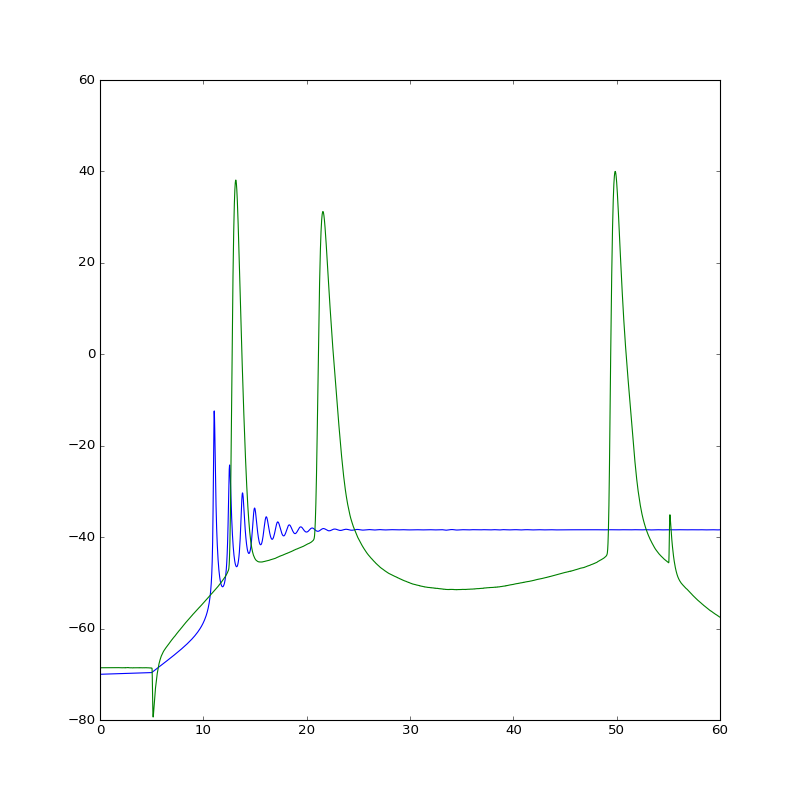

In [8]:
#def plot_responses(responses):
#    fig1, axes = plt.subplots(len(responses))
#    axes = [axes]
#    idx = 0
#    for recording_name, recording in responses.items():
#        axes[idx].plot(recording['time'], recording['voltage'], label=recording_name)
#        axes[idx].legend()
#        idx += 1
     
# plt.legend()
# plt.show()
# plot_responses(responses)
def plot_responses(responses):
    fig1, ax = plt.subplots(len(responses))
    ax.plot(responses['step1.soma.v']['time'], responses['step1.soma.v']['voltage'], label='step1.soma.v')
    ax.plot(steps_dict['ShortStepPos'][0][:, 0], steps_dict['ShortStepPos'][0][:, 1])
plot_responses(responses)


Thanks to another helper class of the BluePyOpt library it is easy to define a simulation. The additional file "cell_evaluator.py" can be used to set up the simulation and define a scoring system that will be used by the genetic algorithm.

In [9]:
# efel_feature_means = {'step1': {'Spikecount': {'mean': 3, 'std': .1} }} # mean_std_features['ShortStepPos']['Spikecount']}}
efel_feature_means = {'step1': {'time_to_first_spike': mean_std_features['ShortStepPos']['time_to_first_spike']}}

# , 'step2': {'Spikecount': 5}}    
                                                                                 
objectives = []                                                                  
                                                                                 
for protocol in sweep_protocols:                                                 
    stim_start = protocol.stimuli[0].step_delay                                  
    stim_end = stim_start + protocol.stimuli[0].step_duration                    
    for efel_feature_name, mean_std_dict in efel_feature_means[protocol.name].iteritems():
        mean = mean_std_dict['mean']
        std = mean_std_dict['std']
        feature_name = '%s.%s' % (protocol.name, efel_feature_name)              
        feature = ephys.efeatures.eFELFeature(                                   
                    feature_name,                                                
                    efel_feature_name=efel_feature_name,                         
                    recording_names={'': '%s.soma.v' % protocol.name},           
                    stim_start=stim_start,                                       
                    stim_end=stim_end,                                           
                    exp_mean=mean,                                               
                    exp_std=std)                                        
        objective = ephys.objectives.SingletonObjective(                         
            feature_name,                                                        
            feature)                                                             
        objectives.append(objective)         
        
score_calc = ephys.objectivescalculators.ObjectivesCalculator(objectives)        

cell_evaluator = ephys.evaluators.CellEvaluator(                                 
        cell_model=simple_cell,                                                  
        param_names=['gnabar_hh', 'gkbar_hh'],                                   
        fitness_protocols={twostep_protocol.name: twostep_protocol},             
        fitness_calculator=score_calc,                                           
        sim=nrn)        

print cell_evaluator.evaluate_with_dicts(default_params)                         


{'step1.time_to_first_spike': 13.47219358530748}


The result of the simulations can be visualized in the different ways. For example, the following function plots the experimental and model responses one on top of the other.

With the following function call we run a simulation with parameters from the original ABI model. We can also print the scores of the original model. This score measures the difference of each eFeature of the model from the experimental one and penalize the eFeatures that display the wider experimental variability (in our case all the features have the same STD). A "perfect" model would have a score close to 0.

In [10]:
# orig_params = json.load(open('orig_parameters.json'))
# l5pc_cell.unfreeze(param_names)
# orig_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values = orig_params)
# plot_data(nwb_data,[23, 36], orig_responses)

# scores =  fitness_calculator.calculate_scores(orig_responses)
# sum = numpy.sum([value for value in scores.values()])
# avg = numpy.mean([value for value in scores.values()])

# print "Sum of all feature values: " + str(sum)
# print "Average of the feature values: " + str(avg)

# 5. Parameters optimization 
We are now ready to run an optimisation. This is a procedure that requires supercomputing resources and can take from some hours to days. AS a proof of concept, we will run two optimization with a small population of individual for a small number of generations.

In [17]:
optimisation = bpopt.optimisations.DEAPOptimisation(                              
        evaluator=cell_evaluator,                                                
        offspring_size = 20)    

After two generations, the model result is not very satisfying.

In [18]:
final_pop, hall_of_fame, logs, hist = optimisation.run(max_ngen=10)               


We run a slightly longer optimization.

In [19]:
print 'Final population: ', final_pop                                            
best_ind = hall_of_fame[0]                                                       
print 'Best individual: ', best_ind                                              
print 'Fitness values: ', best_ind.fitness.values             

best_ind_dict = cell_evaluator.param_dict(best_ind)                              
print cell_evaluator.evaluate_with_dicts(best_ind_dict)                 

Final population:  [[0.4062833602552974, 0.036569206940281936], [0.41095504273072025, 0.03780896598092535], [0.41095504273072025, 0.03780896598092535], [0.41095504273072025, 0.03780896598092535], [0.4063001204228739, 0.03634407031750106], [0.4068019410856358, 0.036419148515070075], [0.41095504273072025, 0.03780896598092535], [0.406296649151597, 0.03634407031750106], [0.41095504273072025, 0.03780896598092535], [0.41095504273072025, 0.03780896598092535], [0.41095504273072025, 0.03780896598092535], [0.41095504273072025, 0.03780896598092535], [0.41095504273072025, 0.03780896598092535], [0.41095504273072025, 0.03780896598092535], [0.387013545212324, 0.03634407031750106], [0.4042875873788543, 0.03436911108137588], [0.4949091627776099, 0.04297565548423664], [0.35085712890063503, 0.02806562981498198], [0.44968421346176957, 0.04297565548423664], [0.44968421346176957, 0.04297565548423664], [0.44968421346176957, 0.04297565548423664], [0.44968421346176957, 0.04297565548423664], [0.4496842134617695

We can also plot the evolution of the feature values from generation to generation. Although the result is not yet satisfying, we can observe a progressive convergence of the model features values toward the experimental ones.

<IPython.core.display.Javascript object>


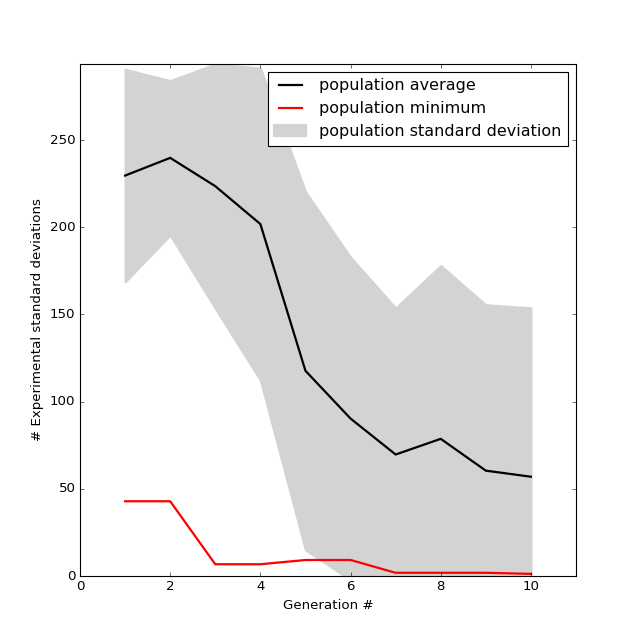

In [20]:
gen_numbers = logs.select('gen')
min_fitness = numpy.array(logs.select('min'))
max_fitness = logs.select('max')
mean_fitness = numpy.array(logs.select('avg'))
std_fitness = numpy.array(logs.select('std'))

fig, ax = plt.subplots(1, figsize=(8, 8), facecolor='white')
#fig_trip, ax_trip = plt.subplots(1, figsize=(10, 5), facecolor='white')

#plot_count = len(responses)
std = std_fitness
mean = mean_fitness
minimum = min_fitness
stdminus = mean - std                                                           
stdplus = mean + std

ax.plot(                                                                      
    gen_numbers,                                                                
    mean,                                                                       
    color='black',                                                              
    linewidth=2,                                                                
    label='population average')                                                 

ax.fill_between(                                                              
    gen_numbers,                                                                
    stdminus,                                                                   
    stdplus,                                                                    
    color='lightgray',                                                          
    linewidth=2,                                                                
    label=r'population standard deviation')                                     

ax.plot(                                                                      
    gen_numbers,                                                                
    minimum,                                                                    
    color='red',                                                                
    linewidth=2,                                                                
    label='population minimum')                                                 

ax.set_xlim(min(gen_numbers) - 1, max(gen_numbers) + 1)                       
ax.set_xlabel('Generation #')                                                 
ax.set_ylabel('# Experimental standard deviations')                                            
ax.set_ylim([0, max(stdplus)])                                                
ax.legend() 

Plotting the voltage responses shows that the result can still be improved.

<IPython.core.display.Javascript object>


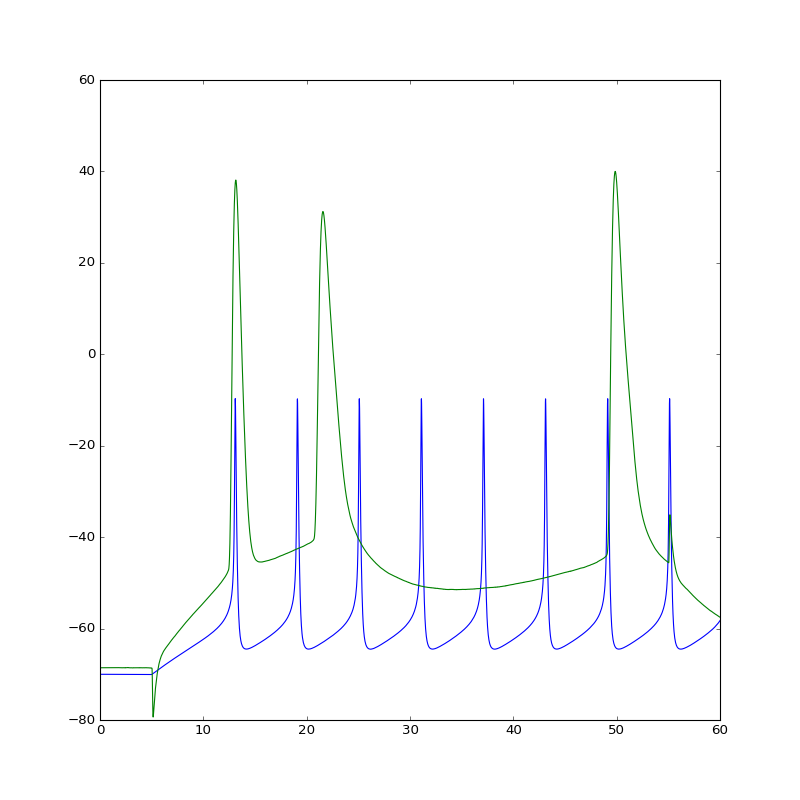

In [21]:
responses = twostep_protocol.run(cell_model=simple_cell, param_values=best_ind_dict, sim=nrn)
plot_responses(responses)

In [22]:
# [0.5939511020692881, 0.05884904370579984]